In [23]:
from transformers.trainer_utils import set_seed
from torch import tensor
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer,BatchEncoding, pipeline
import torch
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm
set_seed(42)


In [2]:
# データ準備

from pprint import pprint
from datasets import load_dataset

train_dataset = load_dataset(
    "llm-book/wrime-sentiment", split="train", trust_remote_code=True
)
valid_dataset = load_dataset(
    "llm-book/wrime-sentiment", split="validation", trust_remote_code=True
)

pprint(train_dataset[0])

{'datetime': '2012/7/31 23:48',
 'label': 1,
 'sentence': 'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…',
 'user_id': 1}


In [31]:
len(train_dataset)

20149

## トークナイザー

In [13]:
from transformers import AutoTokenizer

# Hugging faceからモデルを読み込む
model_name = "tohoku-nlp/bert-base-japanese-v3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(type(tokenizer).__name__) # class名

BertJapaneseTokenizer


In [14]:
tokenizer.tokenize('これはテストです。')

['これ', 'は', 'テスト', 'です', '。']

In [16]:
# tokenizerを関数として扱う場合、BatchEncodingというdict形式のオブジェクトに変換される
encoding_input = tokenizer('これはテストです。')
print(type(encoding_input).__name__)

BatchEncoding


In [17]:
print(encoding_input)

{'input_ids': [2, 12538, 465, 14985, 13037, 385, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [18]:
pprint(encoding_input)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2, 12538, 465, 14985, 13037, 385, 3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


・attention_maskはトークンが有効かどうか（0だと無効）  
・input_idsは各トークンidを示す  
・token_type_idsはセグメント埋め込みのidを示す。

In [22]:
# token_idsのwordへの変換
tokenizer.convert_ids_to_tokens(encoding_input['input_ids'])

['[CLS]', 'これ', 'は', 'テスト', 'です', '。', '[SEP]']

# 統計的可視化

100%|██████████| 20149/20149 [00:03<00:00, 6261.70it/s]


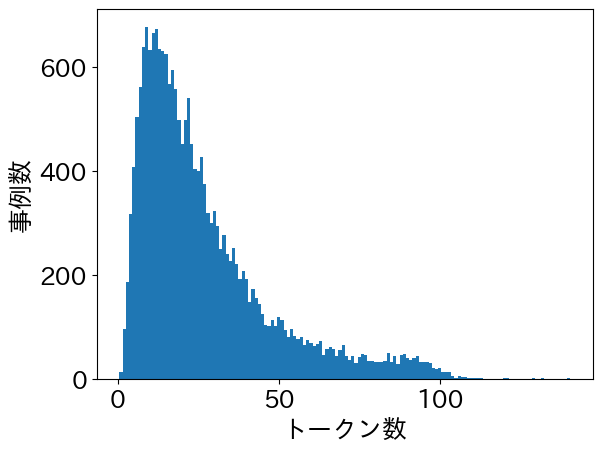

100%|██████████| 1608/1608 [00:00<00:00, 5255.55it/s]


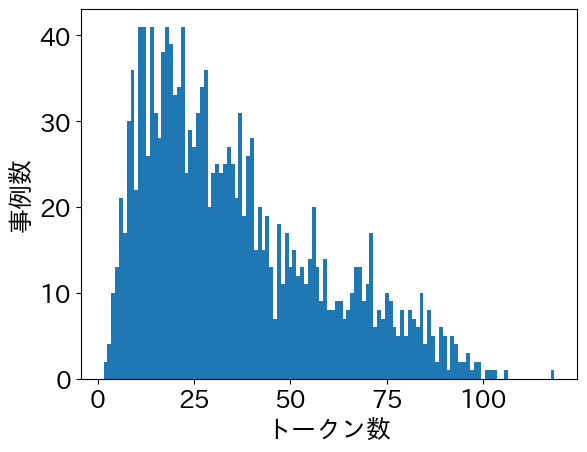

In [37]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams['font.size'] = 18 # pltの初期設定の変更


# トークン数ごとの分布
def visualize_text_length(dataset:Dataset):
    """
    データセット中のテキストのトークン数の分布をグラフとして描画
    """
    # データセット中のテキストの長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data['sentence']))
        length_counter[length] += 1

    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel('トークン数')
    plt.ylabel('事例数')
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

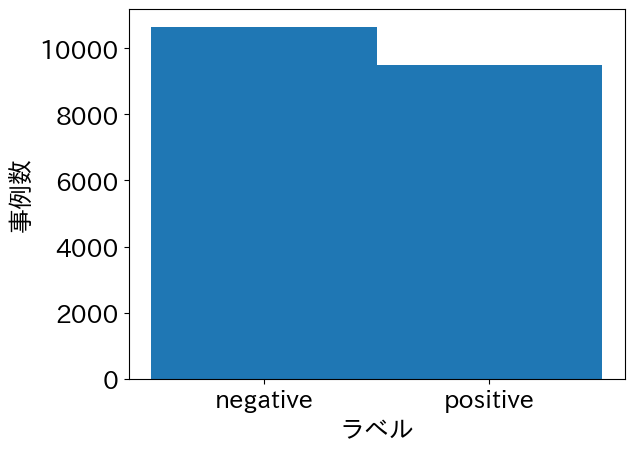

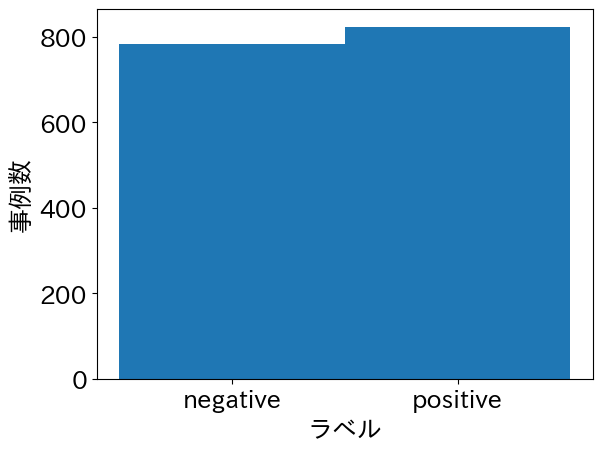

In [40]:
# ラベル{negative, positive}の分布
def visualize_labels(dataset:Dataset):
    label_counter = Counter()
    for data in dataset:
        label_id = data['label']
        label_name = dataset.features['label'].names[label_id]
        label_counter[label_name] += 1

    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel('ラベル')
    plt.ylabel('事例数')
    plt.show()

visualize_labels(train_dataset)
visualize_labels(valid_dataset)

In [54]:
from transformers import BatchEncoding

def prepared_text_classification(example:dict[str, str | int]) -> BatchEncoding:
    encoded_example = tokenizer(example['sentence'], max_length=512)
    encoded_example['label'] = example['label'] # labelキーを追加
    return encoded_example


In [62]:
encoded_train_dataset = train_dataset.map(
    prepared_text_classification,
    remove_columns=train_dataset.column_names
)

encoded_valid_dataset = valid_dataset.map(
    prepared_text_classification,
    remove_columns=valid_dataset.column_names
)

Map:   0%|          | 0/20149 [00:00<?, ? examples/s]

Map:   0%|          | 0/1608 [00:00<?, ? examples/s]

In [66]:
pprint(encoded_train_dataset[0])

{'attention_mask': [1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1,
                    1],
 'input_ids': [2,
               478,
               7139,
               15269,
               441,
               456,
               13123,
               21311,
               12671,
               385,
               12651,
               7065,
               12485,
               12488,
               13781,
               461,
               457,
               13030,
               464,
               461,
               29,
          

## ミニバッチの構築

In [74]:
# padding

# collate関数：バラバラの情報を一つにまとめる
from transformers import DataCollatorWithPadding

# tokenizerを渡してダミートークンを取得させる
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [78]:
# data_collatorの挙動
batch_inputs = data_collator(encoded_train_dataset[0:4])
# 1次元の３６は最長のものにあわせている
pprint({name:tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 36]),
 'input_ids': torch.Size([4, 36]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 36])}


In [81]:
pprint(batch_inputs)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'input_ids': tensor([[    2,   478,  7139, 15269,   441,   456, 13123, 21311, 12671,   385,
         12651,  7065, 12485, 12488, 13781,   461,   457, 13030,   464,   461,
            29,    29,    29,     3,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [    2, 15028,   464,  2806,   484, 30908,   456, 19730,   385,  2724,
          7998, 12505,  6483,   430, 14165,   456, 31265,  7106,   460,  7373,
          

In [84]:
for line in encoded_train_dataset[0:4]['input_ids']:
    print(len(line))

24
36
9
16


In [95]:
# modelの準備

from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features['label']
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}

# ヘッド部分のパラメータはランダムに初期化されている -> もともとあるパラメータは学習済み
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels = class_label.num_classes,
    label2id = label2id, # label2id, id2labelを指定することでpipeline関数のlabel名が出力される
    id2label = id2label
)

print(type(model).__name__)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tohoku-nlp/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


In [101]:
# 上記で作成したdata_collatorをmodelの入力として受け付けるか確認
# logitsはソフトマックスを通す前のスコアのこと
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(0.8075, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.2869, -0.2644],
        [ 0.1715,  0.0095],
        [ 0.0040,  0.1524],
        [ 0.2233, -0.2968]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


## 訓練の実行

In [197]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_marc_ja", # holder of reasult
    per_device_train_batch_size=32, # batch_size
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    lr_scheduler_type='linear',
    warmup_ratio=0.1, # 学習率のウォームアップの長さを指定
    num_train_epochs=3,
    save_strategy='epoch',
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True, # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model='accuracy',
    fp16=True # 自動混合制度演算の有効化 => 学習の使用メモリ量の軽減と速度の向上
)

In [198]:
# モデルの評価方法の設定
import numpy as np

def compute_accuracy(
    eval_pred:tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy":(predictions == labels).mean()}

In [199]:
# 訓練

from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.056500,0.315693,0.928483
2,0.026300,0.385861,0.939055
3,0.041700,0.337166,0.940299


TrainOutput(global_step=1890, training_loss=0.041503255329434836, metrics={'train_runtime': 182.0036, 'train_samples_per_second': 332.12, 'train_steps_per_second': 10.384, 'total_flos': 2736880683965940.0, 'train_loss': 0.041503255329434836, 'epoch': 3.0})

In [114]:
# モデルの評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.9396766169154229,
 'eval_loss': 0.1992902159690857,
 'eval_runtime': 1.4361,
 'eval_samples_per_second': 1119.696,
 'eval_steps_per_second': 35.513}


## モデルの予測結果の取得

In [129]:
from transformers import pipeline

model_name = "llm-book/bert-base-japanese-v3-marc_ja"
marc_ja_pipeline = pipeline(model=model_name, device='cuda:0')

In [147]:
class_label = valid_dataset.features['label']

results: list[dict[str, float | str]] = []

for i, example in tqdm(enumerate(valid_dataset)):
    model_prediction = marc_ja_pipeline(example['sentence'])[0]
    true_label = class_label.int2str(example['label'])

    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction['score'],
            'pred_label': model_prediction['label'],
            'true_label': true_label,
        }
    )

3it [00:00, 26.66it/s]--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/usr/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/usr/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 1075, in launch_i

In [163]:
model_predictions = tqdm(marc_ja_pipeline(valid_dataset['sentence']))

results: list[dict[str, float | str]] = []

for i, (model_prediction, example) in tqdm(enumerate(zip(model_predictions, valid_dataset))):
    true_label = class_label.int2str(example['label'])
    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction['score'],
            'pred_label': model_prediction['label'],
            'true_label': true_label,
        }
    )

100%|██████████| 1608/1608 [00:00<00:00, 27514.40it/s]
1608it [00:00, 28546.69it/s]


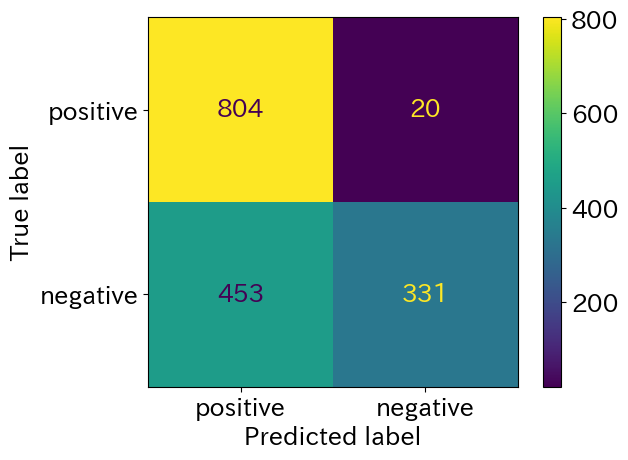

In [178]:
# 混合行列
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams['font.size'] = 18

confusion_matrix = confusion_matrix(
    y_true=[result['true_label'] for result in results],
    y_pred=[result['pred_label'] for result in results],
    labels=class_label.names,
)

ConfusionMatrixDisplay(
    confusion_matrix,display_labels=class_label.names
).plot()

In [238]:
from transformers import TextClassificationPipeline

model_path = "./output_marc_ja/checkpoint-1890/"

trained_model = AutoModelForSequenceClassification.from_pretrained(model_path)

pipe = TextClassificationPipeline(
    model=trained_model, 
    tokenizer=tokenizer,
    device=0  # GPUを使用する場合は、デバイス番号を指定
)


In [239]:
class_label = valid_dataset.features['label']

results: list[dict[str, float | str]] = []

for i, example in tqdm(enumerate(valid_dataset)):
    model_prediction = pipe(example['sentence'])[0]
    true_label = class_label.int2str(example['label'])

    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction['score'],
            'pred_label': model_prediction['label'],
            'true_label': true_label,
        }
    )

1608it [00:17, 92.13it/s]


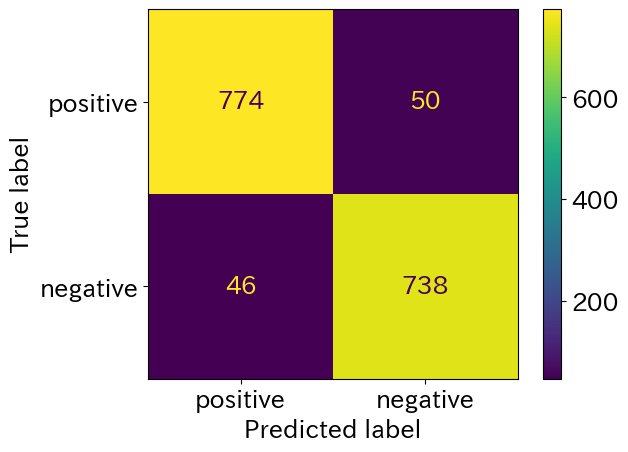

In [240]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams['font.size'] = 18

confusion_matrix = confusion_matrix(
    y_true=[result['true_label'] for result in results],
    y_pred=[result['pred_label'] for result in results],
    labels=class_label.names,
)

ConfusionMatrixDisplay(
    confusion_matrix,display_labels=class_label.names
).plot()

In [266]:
import pandas as pd
df = pd.DataFrame(results)
pred_df = df.set_index('example_id')
pred_df[pred_df['pred_label'] != pred_df['true_label']].sort_values(by='pred_prob', ascending=False )

,pred_prob,pred_label,true_label
example_id,,,
382,0.999888,negative,positive
629,0.999886,negative,positive
1185,0.999857,negative,positive
1597,0.999854,negative,positive
578,0.999852,positive,negative
...,...,...,...
733,0.699132,positive,negative
607,0.651831,positive,negative
216,0.623731,positive,negative


In [297]:
failed_results = [res for res in results if res['pred_label'] != res['true_label']]

# 昇順のため-でソート
sorted_failed_results = sorted(failed_results, key=lambda x: -x['pred_prob'])

# 高い確率で予測しながら誤った事例の上位２つを表示
for top_result in sorted_failed_results[:2]:
    review_text = valid_dataset[top_result['example_id']]['sentence']
    print('レビュー文：',review_text)
    print(f'予想：{top_result["pred_label"]}')
    print(f'正解：{top_result["true_label"]}')
    print(f'予測確率：{top_result["pred_prob"]}')
    print()


レビュー文： というか私のオタク人生に大きな影響を与えすぎたのがクロウ
予想：negative
正解：positive
予測確率：0.9998880624771118

レビュー文： ツイッター早朝部、いくわよ！！ あと諸事情により数人ブロックさせて頂きました…申し訳ない……
予想：negative
正解：positive
予測確率：0.9998859167098999



## 自然言語推論

In [ ]:
# データセットをHugging Faceから読み込む
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="train", trust_remote_code=True
)

valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="validation", trust_remote_code=True
)

print(train_dataset.features['label'])

In [305]:
pprint(train_dataset[3])

{'label': 0,
 'sentence1': '坊主頭の男性が子供を抱いて立っています。',
 'sentence2': '男性が子供を抱き上げて立っています。',
 'sentence_pair_id': '3',
 'yjcaptions_id': '100142-104432-104431'}


In [17]:
def preprocess_text_pair_classification(
    example:dict[str, str | int]
) -> BatchEncoding:
    """
    文字をtokenizeしてidへ変換
    """

    # key: input_idx, token_type_ids, attention_mask
    encoded_example = tokenizer(
        example['sentence1'], example['sentence2'], max_length = 128, truncation=True
    )
    
    # labelの追加
    encoded_example['label'] = example['label']

    return encoded_example
    

In [330]:
# 出力の確認
model_name = "tohoku-nlp/bert-base-japanese-v3"
tokenizer = AutoTokenizer.from_pretrained(model_name)

example = train_dataset[0]

encoded_example = preprocess_text_pair_classification(example)
print(tokenizer.convert_ids_to_tokens(encoded_example['input_ids']))

['[CLS]', '二人', 'の', '男性', 'が', 'ジャンボ', 'ジェット', '機', 'を', '見', 'て', 'い', 'ます', '。', '[SEP]', '2', '人', 'の', '男性', 'が', '、', '白い', '飛行', '機', 'を', '眺め', 'て', 'い', 'ます', '。', '[SEP]']


In [331]:
from transformers import Trainer
model_name = "llm-book/bert-base-japanese-v3-jnli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JNLI", split="validation"
)

encoded_valid_dataset = valid_dataset.map(
    preprocess_text_pair_classification, remove_columns=valid_dataset.column_names
)

trainer = Trainer(
    model=model,
    eval_dataset=encoded_valid_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_accuracy,
)

eval_metrics = trainer.evaluate()
pprint(eval_metrics)

Map:   0%|          | 0/2434 [00:00<?, ? examples/s]

{'eval_accuracy': 0.9063270336894002,
 'eval_loss': 0.40717723965644836,
 'eval_runtime': 5.5364,
 'eval_samples_per_second': 439.638,
 'eval_steps_per_second': 55.09}


In [332]:
nli_pipeline = pipeline(model='llm-book/bert-base-japanese-v3-jnli')
text1 = '川べりでサーフボードをもった人たちがいます'
text2 = 'サーファーたちが川べりに立っています'

nli_pipeline({'text':text1, 'text_pair':})

{'label': 'entailment', 'score': 0.9915270209312439}

## 意味的類似度計算


In [5]:
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JSTS", split="train"
)

valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JSTS", split="validation"
)

pprint(train_dataset[0])
pprint(valid_dataset[0])

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for llm-book/JGLUE contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/llm-book/JGLUE
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

{'label': 0.0,
 'sentence1': '川べりでサーフボードを持った人たちがいます。',
 'sentence2': 'トイレの壁に黒いタオルがかけられています。',
 'sentence_pair_id': '0',
 'yjcaptions_id': '10005_480798-10996-92616'}
{'label': 0.0,
 'sentence1': 'レンガの建物の前を、乳母車を押した女性が歩いています。',
 'sentence2': '厩舎で馬と女性とが寄り添っています。',
 'sentence_pair_id': '0',
 'yjcaptions_id': '100312_421853-104611-31624'}


In [6]:
from transformers import AutoModelForSequenceClassification
transformers_model_name = "tohoku-nlp/bert-base-japanese-v3"
model = AutoModelForSequenceClassification.from_pretrained(
    transformers_model_name, 
    num_labels = 1,
    problem_type = 'regression'
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at tohoku-nlp/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# 回帰の評価指標の定義
import numpy as np
from scipy.stats import pearsonr, spearmanr

def compute_correlation_metrics(eval_pred: tuple[np.ndarray, np.ndarray]) -> dict[str, float]:
    "予想スコアと正解スコアから各種相関係数を計算"
    predictions, labels = eval_pred
    predictions = predictions.squeeze(1)
    return {
        "pearsonr": pearsonr(predictions, labels).statistic,
        "spearmanr": spearmanr(predictions, labels).statistic
    }

In [21]:
model_name = 'llm-book/bert-base-japanese-v3-jsts'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# データセットの準備
valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JSTS", split="validation"
)

encoded_valid_dataset = valid_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=valid_dataset.column_names,
)

trainer = Trainer(
    model=model,
    eval_dataset=encoded_valid_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_correlation_metrics,
)

eval_metrics = trainer.evaluate()
pprint(eval_metrics)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for llm-book/JGLUE contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/llm-book/JGLUE
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/1457 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


[[1.3788556]
 [3.2827663]
 [3.760477 ]
 ...
 [3.3038182]
 [2.3432987]
 [4.6343727]]
(1457, 1)
{'eval_loss': 0.3209794759750366,
 'eval_pearsonr': 0.9190146884140747,
 'eval_runtime': 64.2102,
 'eval_samples_per_second': 22.691,
 'eval_spearmanr': 0.8830043714302008,
 'eval_steps_per_second': 2.85}


In [26]:
text_sim_pipeline = pipeline(
    model="llm-book/bert-base-japanese-v3-jsts",
    function_to_apply = "none" # 出力に適応する関数 => sigmoid関数で０－１の出力になる
)

text1 = '川べりでサーフボードをもった人たちがいます'
text2 = 'サーファーたちが川べりに立っています'

print(text_sim_pipeline({"text":text1, 'text_pair': text2})["score"])


3.645124912261963


## 多岐選択式質問応答

In [27]:
# データセットをHugging Faceから読み込む
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JCommonsenseQA", split="train",
)

valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JCommonsenseQA", split="validation",
)

print(train_dataset[0])

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for llm-book/JGLUE contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/llm-book/JGLUE
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

{'q_id': 0, 'question': '主に子ども向けのもので、イラストのついた物語が書かれているものはどれ？', 'choice0': '世界', 'choice1': '写真集', 'choice2': '絵本', 'choice3': '論文', 'choice4': '図鑑', 'label': 2}


In [45]:
def preprocess_multiple_choice(
    example:dict[str, str]
) -> BatchEncoding:
    # 選択肢の数を"choice"から始まるキーの数として算出
    num_choices = sum(
        key.startswith('choice') for key in example.keys() #-> key.startswith()はboolを返す
    )

    # 質問と選択肢を連結してトークナイザーに渡す
    choice_list = [example[f"choice{i}"] for i in range(num_choices)]
    repeated_question_list = [example["question"]] * num_choices
    encoded_example = tokenizer(
        repeated_question_list, choice_list, max_length=64, truncation=True
    )

    # ラベルが入力にある場合、出力にも追加
    if 'label' in example:
        encoded_example['labels'] = example['label']
    return encoded_example

In [46]:
for i in train_dataset[0].keys():
    print(i.startswith('choice'))

False
False
True
True
True
True
True
False


In [64]:
example = train_dataset[0]

encoded_example = preprocess_multiple_choice(example)

for choice in range(5):
    print(tokenizer.decode(encoded_example['input_ids'][choice]))

[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 世界 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 写真 集 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 絵本 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 論文 [SEP]
[CLS] 主に 子ども 向け の もの で 、 イラスト の つい た 物語 が 書か れ て いる もの は どれ? [SEP] 図鑑 [SEP]


In [132]:
def collate_fn_multiple_choice(features):
    label_name = 'labels'

    batch_size = len(features)
    num_choices = len(features[0]['input_ids'])

    flat_features = []
    for feature in features:
        flat_features += [
            {k: v[i] for k, v in feature.items() if k != label_name} for i in range(num_choices)
        ]


    flat_batch = tokenizer.pad(flat_features, return_tensors='pt')

    batch = {
        k: v.view(batch_size, num_choices, -1)
        for k, v in flat_batch.items()
    }

    if label_name in features[0]:
        labels = [feature[label_name] for feature in features]
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
    return batch

In [133]:
batch_size = 4
encoded_examples = [
    preprocess_multiple_choice(train_dataset[i])
    for i in range(batch_size)
]

batch = collate_fn_multiple_choice(encoded_examples)
pprint({name: tensor.size() for name, tensor in batch.items()})

{'attention_mask': torch.Size([4, 5, 40]),
 'input_ids': torch.Size([4, 5, 40]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 5, 40])}


In [135]:
from transformers import AutoModelForMultipleChoice

model = AutoModelForMultipleChoice.from_pretrained(
    transformers_model_name,
    num_labels = train_dataset.features["label"].num_classes,
)

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at tohoku-nlp/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [136]:
model(**batch)

MultipleChoiceModelOutput(loss=tensor(1.8357, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0749, -0.1777, -0.4318,  0.3543, -0.2538],
        [-0.2200, -0.5048,  0.0775, -0.1600,  0.2931],
        [ 0.2121,  0.2197,  0.2333,  0.0482,  0.0983],
        [ 0.0969,  0.2174,  0.0648,  0.1898,  0.1869]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [138]:
batch['labels']

tensor([2, 1, 3, 4])